# Bomoda Data Engineering Exercise - Exploratory Data Analysis

The goal for this exercise is to develop an ETL solution that cleans the provided page data and creates relations between the other provided files, ultimately joining them as a single CSV file per the schemas described below. The approach you take is purely your choice, but please note that this is a small sample of real data, and as such you should take into account any scaling and edge-case concerns. When you are finished, please push your code to a Github or Bitbucket repository and make it available to us.


**Output Result Schema**

- Article title
- Article URL
- Content without HTML
- Read number
- Like number
- Biz ID
- Biz description
- Biz name
- Publish date


Archive the resulting files as part of the process

The data follows the following data schema:


**Biz - Delimited by tabs**

- `ID`: Source database incremental id
- `Biz ID`: Biz account unique id
- `Biz Name`: Account name shown on the platform
- `Biz Code`: Account registered name
- `Biz Description`: Description of account
- `QRcode`: Account’s QR code
- `Timestamp`: Time of record creation


**Click - Delimited by tabs**

- `ID`: Source database incremental id
- `URL`: Corresponding page URL 
- `Title`: Corresponding page title
- `Read Number`: Page’s read number
- `Like Number`: Page’s like number
- `Timestamp`: Time of record creation


**Page - Raw html data**

- `ID`: Source database incremental id
- `URL`: URL for page content
- `Title`: Page title
- `Content`: Page raw html content *
- `Publish Date`: Date the article was made public *
- `Timestamp`: Time of record creation

> Within the content is a javascript variable “ct” that denotes publish time


Notes:

1. Click data might have duplicate records in terms of URL, please extract the one with maximum read number.
2. Biz ID can be parsed from URL.
3. If the final CSV result is too large to push to repository, please use cloud like google drive to share result with us.


## Loading files

First, I'm going to load all the files from the zip to DataFrames and see if the schema matches description.

I'm going to use Pandas DataFrames, because the data is fairly small (~1.5 GB uncompressed). I know that it's only the subset of the data, and the actual data is much larger. However, this is exploratory data analysis and the purpose of it is to get to know the data, and working on a subset of data is perfectly fine. The final solution will be implemeneted in something more scalable

In [2]:
import pandas as pd
%matplotlib inline

In [3]:
!head -n1 ../wechat_data_medium/weixin_biz

Looks like the data doesn't have a header

In [4]:
biz = pd.read_table("../wechat_data_medium/weixin_biz", names=[
    'id',
    'biz_id',
    'biz_name',
    'biz_code',
    'biz_description',
    'qr_code',
    'timestamp',
], low_memory=False, index_col=False)
biz.head()

id            biz_id   biz_name            biz_code  \
0  2394660  MzIyNjA3ODA0OA==    天津师大史学社  tianshidashixueshe   
1  2394664  MzI5MTEwMzUxMA==      爆笑女神经          bxns666888   
2  2394668  MjM5NTQ0MzQ1Nw==     专治各种不服             zhibufu   
3  2394672  MzIyMDIwMjkyOQ==  名牌皮具厂批发商会                 NaN   
4  2394676  MzIwMjI2NDMzOQ==    说话逻辑与技巧          shuohua148   

                                     biz_description  \
0  天津师大史学社是天津师范大学学生自愿结成的进行历史学习与交流的学术型社团，致力于为广大师大学...   
1                       本平台为您推送史上最最无厘头的搞笑段子，欢迎关注姐！！！   
2  花花世界，无奇不有，汇聚各种奇闻异事，亮点内容，让您的生活从此丰富多彩。不服哥：专治各种不服...   
3  香奈儿LV爱马仕MIUMIU古驰等名牌原版&nbsp;超A原单女包！各名牌经典，各名牌包包最...   
4    教会你如何说话才让人感觉最舒服、最感动;帮助你快速掌握说话的技巧,说话改变命运;口才决定人生!   

                                             qr_code   timestamp  
0  http://mp.weixin.qq.com/mp/qrcode?scene=100000...  1459685449  
1  http://mp.weixin.qq.com/mp/qrcode?scene=100000...  1459685484  
2  http://mp.weixin.qq.com/mp/qrcode?scene=100000...  1459685489  
3  http://mp.weixin.qq.com/mp/qrcode?scene=100000...  1459685495  
4  http://mp.weixin.qq.com/mp/qrcode?scene=100000...  1459685504

Let's run some basic exploratory data analysis

In [5]:
biz.shape

(2559818, 7)

We have 2.5 milion rows and 7 columns

## Checking `biz_id`

Let's check a sample of values

In [6]:
biz.biz_id.sample(n=10)

856986     MzA3MDk0NjMzOQ==
441218     MjM5NzkyNDc2NQ==
850662     MjM5ODk2Nzg2NQ==
1573742    MzAxMDM5NTc3NA==
1955882    MzIwNjI0NzIxNA==
409523     MjM5NDAyMDk0OQ==
2212025    MzA4ODg2MDMyMQ==
1519154    MzA5OTQxMjg3NA==
396943     MzAwOTI1NjA0Mg==
764529     MzI1ODE4NTk0OA==
Name: biz_id, dtype: object

Let's check missing values

In [7]:
biz.biz_id.isnull().value_counts()

False    2559817
True           1
Name: biz_id, dtype: int64

We have a single null value in `biz_id`. Let's check it

In [8]:
missing_biz = biz[biz.biz_id.isnull() | (biz.biz_id.str.len() == 0)]
missing_biz

id biz_id biz_name biz_code biz_description  \
1328037  2236033    NaN      NaN      NaN             NaN   

                                                   qr_code   timestamp  
1328037  http://mp.weixin.qq.com/mp/qrcode?scene=100000...  1453705561

The only information that we have is `timestamp` and `qr_code`.

In [9]:
missing_biz.qr_code.iloc[0]

'http://mp.weixin.qq.com/mp/qrcode?scene=10000004&size=102&__biz='

Let's go back to this when we better understand `qr_code`, maybe we'll be able to match this row to some actual Biz.

In [10]:
biz_id_value_counts = biz.biz_id.value_counts()
biz_id_value_counts.head()

MzA3NjA2NDIxNQ==    2
MzIxNDIyOTMzOQ==    2
MzIyNzIxNTA2Mg==    2
MzI1MjIwNTI4Ng==    2
MzIwODE5NDMyOQ==    2
Name: biz_id, dtype: int64

There are definetely some duplicates. Let's check how many

In [11]:
(biz_id_value_counts >= 2).sum()

13

13 out of 2.5 million, so it's not that much.

In [12]:
duplicated_biz_ids = biz_id_value_counts[biz_id_value_counts >= 2].index

Let's see if we can easily resolve those duplicates

In [13]:
biz[biz.biz_id.isin(duplicated_biz_ids)].drop_duplicates().shape

(13, 7)

Looks like we can simply drop those duplicates

In [14]:
biz = biz.drop_duplicates(subset=['biz_id'])

## Checking `biz_name`

In [15]:
biz.biz_name.sample(n=10)

511086            GM工作室
2315766       MISSVLOVE
1820745    柳林白瑾舞韵舞蹈培训中心
1397401          大肠癌那些事
1855896      道通汽车导航地图升级
287158      青岛一木家具上海直营店
1409278           说话智慧学
780752           老板商业智慧
2062718             银盛祥
1335246            一人一犬
Name: biz_name, dtype: object

In [16]:
missing_biz_name = biz[biz.biz_name.isnull() | (biz.biz_name.str.len() == 0)]
missing_biz_name.shape

(17249, 7)

In [18]:
missing_biz_name.sample(n=10)

id            biz_id biz_name biz_code biz_description  \
2368872  1660075  MzA4ODExMjM1OA==      NaN      NaN             NaN   
2266733  1251519  MjM5MjM4MDQ0Ng==      NaN      NaN             NaN   
2529325  2301887  MzA4ODYzMjQzMw==      NaN      NaN             NaN   
1719249  1431394  MzA4NDk5Njc2MA==      NaN      NaN             NaN   
987162    872533  MzAxNDYxNTY1Nw==      NaN      NaN             NaN   
1732959  1486234  MzAxODA0NDgxMA==      NaN      NaN             NaN   
964200    780685  MzA3MDI3NzAwMA==      NaN      NaN             NaN   
1654667  1173066  MzA3NTgzODEwNw==      NaN      NaN             NaN   
2191286   949731  MzA3MzYwMjYwNw==      NaN      NaN             NaN   
389428    851360  MzAxMjU5MzcwOA==      NaN      NaN             NaN   

                                                   qr_code   timestamp  
2368872  http://mp.weixin.qq.com/mp/qrcode?scene=100000...  1439289148  
2266733  http://mp.weixin.qq.com/mp/qrcode?scene=100000...  1436317324  
2529325  http://mp.weixin.qq.com/mp/qrcode?scene=100000...  1457538874  
1719249  http://mp.weixin.qq.com/mp/qrcode?scene=100000...  1437370602  
987162   http://mp.weixin.qq.com/mp/qrcode?scene=100000...  1434789538  
1732959  http://mp.weixin.qq.com/mp/qrcode?scene=100000...  1437723413  
964200   http://mp.weixin.qq.com/mp/qrcode?scene=100000...  1434577822  
1654667  http://mp.weixin.qq.com/mp/qrcode?scene=100000...  1435929538  
2191286  http://mp.weixin.qq.com/mp/qrcode?scene=100000...  1435014789  
389428   http://mp.weixin.qq.com/mp/qrcode?scene=100000...  1434565463

Observation: There are much more missing names than ids

Maybe QR code has some info?

In [19]:
missing_biz_name.qr_code.sample(10).values

array(['http://mp.weixin.qq.com/mp/qrcode?scene=10000004&size=102&__biz=MzA4NjkwNDEzOQ==',
       'http://mp.weixin.qq.com/mp/qrcode?scene=10000004&size=102&__biz=MzAxNTYzOTk0MQ==',
       'http://mp.weixin.qq.com/mp/qrcode?scene=10000004&size=102&__biz=MzAwOTM4MzIzMg==',
       'http://mp.weixin.qq.com/mp/qrcode?scene=10000004&size=102&__biz=MjM5NDg0OTIwMQ==',
       'http://mp.weixin.qq.com/mp/qrcode?scene=10000004&size=102&__biz=MzA3MjU5MTM5NQ==',
       'http://mp.weixin.qq.com/mp/qrcode?scene=10000004&size=102&__biz=MzA3NDYyNTU3Mg==',
       'http://mp.weixin.qq.com/mp/qrcode?scene=10000004&size=102&__biz=MzA3NjkyNjM3OQ==',
       'http://mp.weixin.qq.com/mp/qrcode?scene=10000004&size=102&__biz=MzA3MzU3MjkzMQ==',
       'http://mp.weixin.qq.com/mp/qrcode?scene=10000004&size=102&__biz=MzA4NjAwMTI3MA==',
       'http://mp.weixin.qq.com/mp/qrcode?scene=10000004&size=102&__biz=MzIyMTAwMTg1OQ=='],
      dtype=object)

Looks like QR code has only Biz ID in it.

Let's check duplicates

In [20]:
biz_name_value_counts = biz.biz_name.value_counts()
biz_name_value_counts.head(n=10)

新注册公众号           37066
美文心赏               321
IMU幻响LED智能护眼灯      315
Q2485738554        218
韩国ZINGO柠檬杯         205
心灵日记               197
成功新天地              184
陈安之                174
智慧人生               160
健康养生               118
Name: biz_name, dtype: int64

In [21]:
print((biz_name_value_counts >= 2).sum())
print(biz_name_value_counts[biz_name_value_counts >=2].sum())

99698
325377


Looks like 99698 biz names are duplicated, and in total they occur in 325377 rows.

It's hard for me to judge if that's ok or not. I can try to translate some of the names to see if they're not some "encodings" like "empty value" in chinese, and they really mean that there is no value.

In [64]:
import sys

In [65]:
!{sys.executable} -m pip install googletrans

  Running setup.py bdist_wheel for googletrans ... done
  Stored in directory: /Users/mateusz/Library/Caches/pip/wheels/65/11/fc/44d36c61c9a0405de9f46022f503de767b95003065b448aed3
Successfully built googletrans
You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [22]:
from googletrans import Translator
translator = Translator()

In [23]:
translations = [translator.translate(text).text for text in biz_name_value_counts.head(n=10).index]
translations

['Newly registered public number',
 'Appreciation of the United States',
 'IMU LED smart eye lamp',
 'Q 485738554',
 'Korea ZINGO Lemon Cup',
 'Diary of mind',
 'New world of success',
 'Chen Anzhi',
 'Smart life',
 'Healthy health']

The first entry, which occurs 37066 times is likely some placeholder.

**We could replace it with null. I'm not going to do this right now, but it's one of the question I'd have to the team.**

Let's see the distribution of lengths of texts, to check if there are any outliers.

In [24]:
import numpy as np
biz_name_len = biz.biz_name.str.len()
biz_name_len.describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.999]).astype(int)

count    2542556
mean           6
std            2
min            1
50%            6
75%            8
90%           10
95%           12
99.9%         22
max          200
Name: biz_name, dtype: int64

Looks like there is an outlier with 200 characters len

In [25]:
biz_long_names = biz.loc[biz_name_len[biz_name_len > 20].sort_values(ascending=False).index]
print(biz_long_names.shape)
biz_long_names

(3712, 7)


id            biz_id  \
2113012   636635  MzAwMDAxMTY1NQ==   
1144765  1502945  MzA3Mjk0MjQyNg==   
1483349   487794  MzA4NDg1OTAzNA==   
782503     53897  MzAxMjI2MDE1MQ==   
2493125  2157087  MzA5ODAzMTcyOQ==   
612301   1742852  MzA3NDA3MTMyNQ==   
205221    114532  MzAwMzEyMjUwMg==   
1953116  2366862  MjM5MDY4Mzc2MA==   
925960    627725  MzA5OTE4NDc4OQ==   
1000451   925689  MzA4NTIxNjgyNg==   
768796   2368832  MzA3ODA5ODAwOQ==   
2431951  1912391  MzAxNTIyNTQ1NA==   
1601893   961970  MjM5ODExMzA5NQ==   
1540428   716110  MzAxMzAxMTQwMA==   
1426634   260934  MjM5NDQzMDY2Nw==   
832182    252613  MjM5MzkxNjQzNg==   
1454599   372794  MzA3MzAwMDU2NQ==   
838088    276237  MjM5NTU2NTMxMg==   
899018    519957  MzA4ODE1NjMxMw==   
140465   2551284  MzAwNzc0NzIzMA==   
1126629  1430401  MzAxMDE3NDM2MA==   
1440539   316554  MjM5ODI3ODA0NQ==   
643454   1867464  MzA3NDAwNTI5Ng==   
1460753   397410  MzA3NTU2OTExMw==   
1695351  1335802  MzA5OTA2OTUzNw==   
1310290  2165045  MzA5MTQwMDcxNw==   
253485    307588  MjM5NzY2OTgzMw==   
818604    198301  MjM5MDM0NzY5NA==   
1071659  1210521  MzAxODAzODExNg==   
259781    332772  MjM5OTM2MjY2MA==   
...          ...               ...   
1150330  1525205  MzA4NDE2ODcyMw==   
1154837  1543233  MzA3NjI2MTgzNQ==   
1156498  1549877  MzA5NjA5OTIyOQ==   
1157205  1552705  MzA3ODMwODAzMw==   
1164812  1583133  MzI1MDAwNzY2MQ==   
1169760  1602925  MzIwNDAzNDc2Nw==   
1179345  1641265  MzI0OTAzODQ4OQ==   
1105052  1344093  MzA4ODM3NDQzOQ==   
1092716  1294749  MzAwODA0NDg2OA==   
1033717  1058753  MzA4NzI4NDcyOA==   
1062386  1173429  MzA4NDAyMjI2OQ==   
1035313  1065137  MjM5MjAyMjc5Nw==   
1043036  1096029  MzA5ODM4ODUwNg==   
1049351  1121289  MzA4MTA4ODExNA==   
1049780  1123005  MzA4NDMwNjI2MA==   
1053026  1135989  MzIzMjAwOTAyNw==   
1054983  1143817  MjM5NDAzNzczNQ==   
1059136  1160429  MzA4MzM2NzcxMA==   
1061802  1171093  MzAwODE4ODczOQ==   
1062588  1174237  MzAxNDE1NDE0OQ==   
1084806  1263109  MzAwMDE1NTY1NQ==   
1067680  1194605  MzA4NzczMjYyNA==   
1072439  1213641  MzA4NzMxODcwNg==   
1074922  1223573  MzA3MDU1MzYwNA==   
1075347  1225273  MzI2MDAwMzI4Mw==   
1077344  1233261  MzA3OTAzMzMzNA==   
1080017  1243953  MzAxMDI3OTA3Mw==   
1082018  1251957  MzAwMTAyMzI4OA==   
1082580  1254205  MjM5ODAwMTU2OQ==   
945      2398440  MzAwNTMyMjY1MQ==   

                                                  biz_name  \
2113012  呵呵&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&n...   
1144765  中孟贸易&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;...   
1483349  爱&nbsp;sm8336&nbsp;sm8337&nbsp;sm8755&nbsp;sm8...   
782503   知味&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&n...   
2493125  纤纤美业&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;...   
612301   TRBJU&nbsp;-&nbsp;TRUE&nbsp;RELIGION&nbsp;BRAN...   
205221   搞笑女神simi2015&nbsp;ysh5511&nbsp;rrniubi&nbsp;yi...   
1953116  sunny&#39;s&nbsp;zakka&nbsp;hand&nbsp;made&nbs...   
925960   IWA&nbsp;(International&nbsp;Water&nbsp;Associ...   
1000451  健康&nbsp;&nbsp;养生&nbsp;休闲&nbsp;&nbsp;&nbsp;&nbs...   
768796   沈&nbsp;阳&nbsp;装&nbsp;修&nbsp;设&nbsp;计&nbsp;e&nb...   
2431951   依然汗蒸瑜伽会馆&amp;nbsp;&amp;nbsp;&amp;nbsp;&amp;nbsp;   
1601893    台&nbsp;湾&nbsp;J&nbsp;&amp;&nbsp;K&nbsp;影&nbsp;像   
1540428    内涵小师妹ap5050&nbsp;v5aabb&nbsp;ztv555&nbsp;ppp776   
1426634    Fashion&nbsp;Tv&nbsp;Club&nbsp;by&nbsp;Babyface   
832182     Cultural&nbsp;Care&nbsp;Au&nbsp;Pair&nbsp;China   
1454599    脸红那些事sm8337&nbsp;sm8875&nbsp;sm7588&nbsp;auv788   
838088      冬日暖阳&nbsp;warm&nbsp;&amp;&nbsp;love&nbsp;notes   
899018        吉开门业&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;开门大吉   
140465         First&nbsp;National&nbsp;Waverley&nbsp;City   
1126629        Thaihot&nbsp;Hotels&nbsp;&amp;&nbsp;Resorts   
1440539        MODERN&nbsp;RAILWAYS铁路展及METRO&nbsp;CHINA城轨展   
643454          Little&nbsp;Scholar&nbsp;Academy&nbsp;德意学堂   
1460753         澳洲品牌达人AUSTRALIAN&nbsp;INDULGENCE&nbsp;CLUB   
1695351          享未来&nbsp;&nbsp;&nbsp;素养人生&nbsp;&nbsp;健康是福   
1310290          N殿&nbsp;发型设计&nbsp;眉&nbsp;唇&n

Looks like those long names have a lot of html-escaped "hard spaces" (`&nbsp;`) in them. There are also some other HTML encoded characters like `&amp;`. Some rows have even more broken encodings like `&amp;nbsp` which probably result from "double" html excaping. We should probably try to clean it.

In [26]:
(biz_long_names.biz_name.str.count('&nbsp;') >= 1).sum()

1607

Looks like ~ 50% of the records have at least a single 'nbsp'

Let's clean it

In [27]:
import html

def double_unescape_html_text(text):
    if not pd.isnull(text):
        return html.unescape(html.unescape(text)).replace('\xa0', ' ')
    else:
        return text

In [28]:
biz['clean_biz_name'] = biz.biz_name.map(double_unescape_html_text)

In [29]:
clean_biz_name_len = biz.clean_biz_name.str.len()
clean_biz_name_len.describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.999]).astype(int)

count    2542556
mean           6
std            2
min            1
50%            6
75%            8
90%           10
95%           12
99.9%         20
max           47
Name: clean_biz_name, dtype: int64

Looks more reasonable now

In [30]:
biz.loc[clean_biz_name_len[clean_biz_name_len > 20].sort_values(ascending=False).index].head()

id            biz_id  \
1483349  487794  MzA4NDg1OTAzNA==   
998422   917573  MzAxMDEyMjQyMg==   
785035    64025  MjM5NDY0NTk2MA==   
205221   114532  MzAwMzEyMjUwMg==   
908953   559697  MzA5MjExMTY5NA==   

                                                  biz_name      biz_code  \
1483349  爱&nbsp;sm8336&nbsp;sm8337&nbsp;sm8755&nbsp;sm8...      nvrenwzc   
998422             脸红auv8899那iilian6些aaashy8事xiaoshimei992       vip8784   
785035              夜遇nvr369美zvip521丽xvip555和zvipxo和nrnr36  tianshengmei   
205221   搞笑女神simi2015&nbsp;ysh5511&nbsp;rrniubi&nbsp;yi...        VIPdud   
908953               坏丫头vipwysmh小nvren238丫simi365头simi8090        NTF000   

                                        biz_description  \
1483349  小妹每天会在这里陪你爽，陪你嗨哦！&nbsp;记得要关注小妹，小妹有好多爽爽的精彩等着你哦！   
998422                                      每天晚上更新，等你来哦   
785035   都市是繁华的，惟其繁华，所以喧嚣，人在其中，最易迷失自己，我是夜遇女人！火速点击下面关注哦！   
205221                           男人的终极禁地，女人的私密花园，欢淫关注哦！   
908953                                     我是坏丫头，有胆你就来！   

                                                   qr_code   timestamp  \
1483349  http://mp.weixin.qq.com/mp/qrcode?scene=100000...  1434730000   
998422   http://mp.weixin.qq.com/mp/qrcode?scene=100000...  1434920490   
785035   http://mp.weixin.qq.com/mp/qrcode?scene=100000...  1434742403   
205221   http://mp.weixin.qq.com/mp/qrcode?scene=100000...  1434752704   
908953   http://mp.weixin.qq.com/mp/qrcode?scene=100000...  1434730000   

                                          clean_biz_name  
1483349  爱 sm8336 sm8337 sm8755 sm8875 vip88375 hehe5966  
998422           脸红auv8899那iilian6些aaashy8事xiaoshimei992  
785035            夜遇nvr369美zvip521丽xvip555和zvipxo和nrnr36  
205221            搞笑女神simi2015 ysh5511 rrniubi yishen233  
908953             坏丫头vipwysmh小nvren238丫simi365头simi8090

## Checking `biz_code`

I'm not going to check biz_code in details, because it's not required in the output schema.

In [31]:
biz.biz_code.sample(n=10)

310559     LianshengMarket
1054186          TD-PHOTOS
194580                 NaN
71886                  NaN
2013362            xhlyszx
61402                  NaN
865419           SunBasket
1010622    meiguozhilv1980
455125             hdsptyd
135171         qy993562871
Name: biz_code, dtype: object

In [32]:
missing_biz_code = biz[biz.biz_code.isnull() | (biz.biz_code.str.len() == 0)]
missing_biz_code.shape

(568171, 8)

## Checking `biz_description`

In [33]:
biz.biz_description.sample(n=10)

2230154                                                中央电视台
1611438                       vmsky.com是国内最早、全球最大的中文虚拟化技术社区。
1843178    关注莞工文学院志愿服务站，了解最新志愿动态。蒲公英，让爱随风传递！趣味涂鸦、福利院学习班辅导...
190172                                热帖头条，八卦资讯，奇闻异事，网罗天下新鲜事
676708     女人的美丽不仅仅存在于外表，而应该源自内在的品质——&nbsp;充满自信、充满激情、从容的平...
992831                                                   NaN
1045219    致力于终身教育（学历教育、会计培训、职业技能培训、高校毕业生创业和职业综合能力培训），是您培...
222930             冠世网是提供枣庄本地优质生活服务信息的社交平台。分享点滴，品质生活，欢迎加入冠世网
1988671                                            牵手心搜，商机无限
442902                      发布酒店的最新动态（包括酒店新闻、创新菜肴推出、促销优惠活动等）
Name: biz_description, dtype: object

In [34]:
missing_biz_description = biz[biz.biz_description.isnull() | (biz.biz_description.str.len() == 0)]
missing_biz_description.shape

(18803, 8)

In [35]:
biz_description_len = biz.biz_description.str.len()
biz_description_len.describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.999]).astype(int)

count    2541002
mean          51
std           87
min            1
50%           40
75%           77
90%          112
95%          120
99.9%        263
max        65527
Name: biz_description, dtype: int64

Looks like in description there are also some outliers

In [36]:
biz_long_descriptions = biz.loc[biz_description_len[biz_description_len > 200].sort_values(ascending=False).index]
print(biz_long_descriptions.shape)
biz_long_descriptions

(7346, 8)


id            biz_id          biz_name             biz_code  \
394570    871928  MzAxMjM2MTczNQ==       MaShaolong的       mashaolong-716   
1791596  1720782  MzA5NzYzNTQ4Mw==                逗知                  NaN   
320402    575256  MzA5Mzc5MTI2Mg==              璐成教育             lcjy-365   
1450601   356802  MzA3MTQ1MzI3OA==               成就你             CJNF2014   
1536382   699926  MzAxMDIxMzUzMw==            美若似水年华             mei18age   
2369088  1660939  MzA4MzE4NDY1MA==      卓越领尚Gone简一制作                  NaN   
646362   1879096  MzI4MjA0OTA3MQ==              点滴阅读          diandidushu   
1827877  1865906  MzA3MjI5Mzk1MQ==             一起学美搭         wlykelly1984   
193647     68236  MzAwMTU4MjgxNQ==          天狮事业网上运作              TSSY666   
1532608   684830  MzAwNzUzMzIxMg==                汤圆                  NaN   
1747284  1543534  MzA3NTQ3NjM3Mw==            南阳欧普橱柜           oupuchugui   
1066567  1190153  MzI3MTAwMjY5NA==              周易算卦        suyunfeng8899   
686272   2038736  MzI2NTAyMTA3NQ==                芊芊      qianqian2015612   
2254769  1203663  MzA3MzA1NTY0NA==            群众群特通告               ENA1st   
2080773   507679  MzA4NjgxNjk4OA==              玛丽风尚                  NaN   
670045   1973828  MzIwNjA0MDExOQ==           龙都生活好帮手              ldshhbs   
1464243   411370  MzA3NzA0MjI3Nw==         重庆科技学院学生会            cqust-xsh   
936775    670985  MzAwNTQ3MDAzMw==      GSGforex外汇平台             GSGforex   
1782305  1683618  MzA4MTEzOTU1OQ==          汉诺威自酿啤酒屋                  NaN   
1782420  1684078  MzI4MDAyMzkxNg==            鲅鱼圈共青团              byq_gqt   
1755515  1576458  MzIwNTAzMjE5Mw==             舒伟健康园           shuwei8848   
770584   2375984  MzI1MDA0MTk4Ng==            北京非凡生活           ffshpt2016   
1765212  1615246  MzIyMTAzMTY5Ng==            歪not择业           whynotzeye   
1056614  1150341  MzAwMjY0MzI4Nw==               莫明堂            mmingtang   
1071349  1209281  MzA4NzAzMTM0NA==             莆田报关行                  NaN   
2478148  2097179  MzA4MDE2NzI0NQ==             瑜伽慢生活         YogaFL888666   
2120219   665463  MzAwNDQxNzI4Nw==            紅雨庭流行坊            hytlxf520   
2046950   372387  MzA3MzA2Nzg5Nw==        皇室工匠3D艺术软包               HSGJRB   
690728   2056560  MzA3OTI3NDg1NQ==              仙女花园                  NaN   
2444851  1963991  MzA4NDg0Njk4OQ==            ysmart                  NaN   
...          ...               ...               ...                  ...   
780067     44153  MzAwODM4MjAxOA==         NewsTurbo            NewsTurbo   
2203352   997995  MzIwMTIzODg4MA==                梁巧                  NaN   
2384270  1721667  MzAxODMxMjc5Mg==            南阳尾货服装               whfz99   
1466456   420222  MzA3NzgzMTgxOA==     音乐房子livehouse                  NaN   
2220069  1064863  MzA5MTYxODIyNQ==          关爱肾脏同舟共济    KidneyCare_TongJi   
774303   2390860  MzI3MzIwMzUwNw==  正品NB运动鞋AJ篮球鞋外贸批发                  NaN   
613199   1746444  MzIzNTA0NDE4MQ==              弥陀之爱               fyin18   
357184    722384  MzAxNDAxMjI1NQ==           银河之星幼儿园              yhzxyey   
1497112   542846  MzA5MDQ2NDU5OA==              奥工装饰         ag2930816898   
1106070  1348165  MzIwNTAxMjM2MQ==          悦香台湾美食原料                  NaN   
48037    2457742  MzI0NjI3MzQ1Mw==             青县便民圈      qingxianquan798   
1905190  2175158  MzIwMTUxMDcwNg==            陆河推广传媒                  NaN   
931208    648717  MzAwMjAyMDcxMQ==          娇颜平价洗化超市    JYPJXH13839802776   
427911   1005292  MzA5MTMwNTMwMA==              八一彩印          QQ815063118   
1114646  1382469  MzA5NTkwNDIyMQ==       青岛良木家具寿光旗舰店       qingdaoliangmu   
422497    983636  MjM5MjU3ODczOA==              SICC           SICCOFFICE   
576073   1597940  MzA5MzU4MDQ2Ng==              贞子漫画                  NaN   
419150    970248  MzAxNDM3NjUzMg==             桃花苑土鸡            thy616888   
950679    726601  MzAxNDQxNjk3NQ==    CulinaryCapers  CulinaryCapersChina   
951125    728385  MzAxNTAwNjEwOA==        齐市自行车运动俱乐部             TREK0452   
815449    

In [37]:
biz_long_descriptions.iloc[0].biz_description[:100]

'无副作用&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;'

Looks like the same problem as with `biz_name`. However, there is also an issue with excessive space. I'm going to remove it, because likely it doesn't bring much value.

In [38]:
biz['clean_biz_description'] = biz.biz_description.map(double_unescape_html_text).str.replace('\s+', ' ')

In [39]:
clean_biz_description_len = biz.clean_biz_description.str.len()
clean_biz_description_len.describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.999]).astype(int)

count    2541002
mean          47
std           35
min            1
50%           38
75%           73
90%          106
95%          116
99.9%        135
max         5937
Name: clean_biz_description, dtype: int64

In [40]:
clean_biz_long_descriptions = biz.loc[clean_biz_description_len[clean_biz_description_len > 150].sort_values(ascending=False).index]
print(clean_biz_long_descriptions.shape)
clean_biz_long_descriptions

(329, 9)


id            biz_id          biz_name             biz_code  \
2254769  1203663  MzA3MzA1NTY0NA==            群众群特通告               ENA1st   
909155    560505  MzA5MjI5MzI2MQ==         合肥氧宜多生态硅藻             HF_Odour   
510529   1335764  MzA3ODc2NzI5Ng==         北京皮克布克烟台站   pikebukeyantaizhan   
344533    671780  MzAwNTU0NDM1MQ==            黄岐巨圣女鞋            juusnn888   
1803904  1770014  MzIzODA0ODM0MA==             秀容微生活                  NaN   
1817355  1823818  MzA4OTcyOTcxMw==         华隆泰便利连锁超市          lht19781016   
105388   2515093  MzIyOTAxMzY5Nw==        加宝地板金昌服务中心  jiabaojc15214174568   
2253244  1197563  MzA4NDA0NjM1MA==              六一护肤             Ddjh9690   
632169   1822324  MzAxNjY3MDA4Mw==             台湾帮女郎        an15725482433   
917256    592909  MzA5NTU4NDEwMA==                闺蜜               gm8111   
1065033  1184017  MzAwODY1NDYxMQ==     古钱币私下交易免费鉴定中心                  NaN   
2162859   836023  MzAwMDUxNjYzNA==         星艺装饰丰顺分公司                  NaN   
948689    718641  MzAxMzM1MjExNg==                尘封           V270085423   
1166918  1591557  MzAwOTY2NTU0MQ==            睿美徒手精雕        RM13780629401   
1065959  1187721  MzA3OTc4MDE4MQ==              伊世茗尚          tb985611163   
379698    812440  MzA4NzU2MDQ5Mg==            澳门四季酒店              FSMacau   
1755809  1577634  MzI1NjAyMTcwOQ==            新注册公众号              QJMIFYS   
2166769   851663  MzAxMTA0MjY2NA==         阳谷户外运动俱乐部    yangguhuwaijvlebu   
662589   1944004  MzA4OTUzNTkzMQ==             神农谷祛痘      shennongguqudou   
1205265  1744945  MzIxODA0NTM1Nw==    古玩古董私下交易免费鉴定平台                  NaN   
1568689   829154  MzA5NTY2MjQzMQ==         九职院学生会女生部                  NaN   
1084952  1263693  MzI2MTAwNDUyNA==     古钱币私下交易免费鉴定平台                  NaN   
2242480  1154507  MzAxMjYzOTk5NQ==         Ammy的心情日记               Ammy-U   
1027720  1034765  MzA4OTg4MTExNQ==          沁园净水寒亭专卖       hantingqinyuan   
1718422  1428086  MzA3NDU2MjMyMQ==          一秒文化培训团队         wanjiayimiao   
2078404   498203  MzA4NTgyMTMwMg==                名言              HOT0092   
1584187   891146  MzA3Nzc2ODU2OA==          小丸子和她的卡农          aimarch1996   
1806949  1782194  MzA5MzE1ODQ3NQ==       美丽小铺华阳秀水三号店                  NaN   
1760785  1597538  MzAxNDQ3NTcyMg==              道成禅修   daochengchanxiu007   
2370698  1667379  MzI5MjAyNzU1OA==           张辉弟子侃营销         zhanghuidizi   
...          ...               ...               ...                  ...   
1594239   931354  MzAwODE2OTI3Nw==              临清口腔               lqkqyy   
1103182  1336613  MjM5NTQ1OTYyMA==   北镇青岩寺（歪脖老母）公众平台    qingyansiyangming   
2396947  1772375  MzI2NzAzODY3Mg==           盛通汽车俱乐部            hnstqcjlb   
1670441  1236162  MzA4OTkwNDE5OQ==      盐城市小荷花舞蹈艺术中心               yc-xhh   
1119437  1401633  MzAwMTI3NzEwOA==              澳尚置业            AUSUNCITY   
1590237   915346  MzAxNTYwNTU2Ng==                田龙                  NaN   
1571995   842378  MzAwNjM4MzcyNQ==          邑展地产有限公司         qq2453513389   
1538733   709330  MzAxMjA0ODE3Ng==  小投资零风险教你开网店微店田艳芳              tyf1403   
1254003  1939897  MjM5Mzc1NDg3MQ==             潘俊贤官号    panjunxianguanhao   
1648840  1149758  MzAwODUzMDczOA==            天华建筑四所                  NaN   
2271895  1272167  MzIzMzAxMDkyMw==             8点整体训             PEstart8   
1684599  1292794  MzA5OTIxNzU2Mg==             韩妆购美丽         A15845486706   
639504   1851664  MzI1ODA0MTYzOQ==   金童jintongbaobei      BJjintongbaobei   
2125737   687535  MzAwODI5NDMzNA==             喜维丽商贸                  NaN   
532042   1421816  MzA4NTkyNDc3NA==         好孩子好妈妈俱乐部            hhzhmmjlb   
2110637   627135  MzA5OTAyNTY2MA==     温州九龙生态园旅游有限公司         WZJL64892222   
2086654   531203  MzA4OTIwMDUzNA==            震不倒的房子               zbddfz   
555751   1516652  MzI2OTAxOTI0NA==            婕斯环球商机              JNS1078   
2166585   850927  MzAxMjMyMTYyMQ==      临沂财鑫钢铁集团有限公司                  NaN   
620873   1777140  MzIxOTA0NTYzNg==               小月巴                  NaN   
373095    

In [41]:
clean_biz_long_descriptions.clean_biz_description.iloc[0][:100]

'群众群特的通告平台！<br/>片酬在150元/天以内！<br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br'

Looks like there is still a problem with `<br>` html tags. Let's replace them with simple newlines, and combine combine subsequent newlines.

In [42]:
biz['clean_biz_description'] = biz.clean_biz_description.str.replace('(<br/>\s*)+', '\n')
clean_biz_description_len = biz.clean_biz_description.str.len()
clean_biz_description_len.describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.999]).astype(int)

count    2541002
mean          47
std           34
min            1
50%           38
75%           72
90%          105
95%          115
99.9%        121
max          200
Name: clean_biz_description, dtype: int64

Looks more reasonable now!

In [43]:
clean_biz_long_descriptions = biz.loc[clean_biz_description_len[clean_biz_description_len > 150].sort_values(ascending=False).index]
print(clean_biz_long_descriptions.shape)
clean_biz_long_descriptions

(5, 9)


id            biz_id      biz_name         biz_code  \
379698    812440  MzA4NzU2MDQ5Mg==        澳门四季酒店          FSMacau   
662589   1944004  MzA4OTUzNTkzMQ==         神农谷祛痘  shennongguqudou   
1231945  1851665  MzIyNTAyODcxMQ==       平安保险黄彩凤   hcf18624225955   
2236811  1131831  MzA4MDgyNDg5Ng==  HereProperty              NaN   
1776794  1661574  MzAwMzQ5MTU5Nw==    独立民谣唱作人茶季杨              NaN   

                                           biz_description  \
379698   矗立於連接氹仔島及路環島的金光大道上，澳門四季酒店位置優越、交通四通八達。酒店樓高20層，設...   
662589   “神农谷”系列产品是宏森科技与广州杨森生物联合研发的一款针对于青春痘，痤疮、粉刺、美白、爽肤...   
1231945  黄&nbsp;彩&nbsp;凤\u000B1997----加盟平安\u000B2000---...   
2236811  HERE&nbsp;property(恒远国际地产)是昆士兰房地产投资开发里最具潜力和诚信的...   
1776794  &nbsp;独立原创民谣歌者。\u000B小时候梦想着当飞行员、篮球明星，可最后却阴错阳差的...   

                                                   qr_code   timestamp  \
379698   http://mp.weixin.qq.com/mp/qrcode?scene=100000...  1434592195   
662589   http://mp.weixin.qq.com/mp/qrcode?scene=100000...  1444182466   
1231945  http://mp.weixin.qq.com/mp/qrcode?scene=100000...  1441365558   
2236811  http://mp.weixin.qq.com/mp/qrcode?scene=100000...  1435715274   
1776794  http://mp.weixin.qq.com/mp/qrcode?scene=100000...  1439319483   

        clean_biz_name                              clean_biz_description  
379698          澳门四季酒店  矗立於連接氹仔島及路環島的金光大道上，澳門四季酒店位置優越、交通四通八達。酒店樓高20層，設...  
662589           神农谷祛痘  “神农谷”系列产品是宏森科技与广州杨森生物联合研发的一款针对于青春痘，痤疮、粉刺、美白、爽肤...  
1231945        平安保险黄彩凤  黄 彩 凤\u000B1997----加盟平安\u000B2000----营业部经理\u00...  
2236811   HereProperty  HERE property(恒远国际地产)是昆士兰房地产投资开发里最具潜力和诚信的地产销售及...  
1776794     独立民谣唱作人茶季杨   独立原创民谣歌者。\u000B小时候梦想着当飞行员、篮球明星，可最后却阴错阳差的抱起了吉他...

In [44]:
clean_biz_long_descriptions.clean_biz_description.values

array(['矗立於連接氹仔島及路環島的金光大道上，澳門四季酒店位置優越、交通四通八達。酒店樓高20層，設360間優雅舒適的客房包括84間套房、5所高級食府、5個室外游泳池、2,000平方米的水療及健身設施、2,500平方米的會議及宴會設施，並與樓高3層薈萃頂級名牌的四季名店及澳門威尼斯人會展中心相連。酒店之中餐廳「紫逸軒」自2009年起被米芝蓮港澳飲食指南評選為兩星米芝蓮餐廳，吸引不少喜愛粵菜的客人慕名而來。',
       '“神农谷”系列产品是宏森科技与广州杨森生物联合研发的一款针对于青春痘，痤疮、粉刺、美白、爽肤五位一体的纯中草药产品套装。“神农谷”享有中国祛痘领先品牌美誉是中国祛痘产品十强企业。产品秉承了中华传统文化中最神奇最悠久的中医药理。原材料全部来自于神秘的神农架大峡谷。“神农谷”品牌借助了神农架的天然资源，是在一个致力于改变肌肤问题，从根本上调理肌肤的全面健康，兼具安全与效果的药妆品牌',
       '黄 彩 凤\\u000B1997----加盟平安\\u000B2000----营业部经理\\u000B所获荣誉：\\u000B全球华人寿险美国MDRT\\u000B百万圆桌荣誉会员\\u000B中国平安人寿辽宁分公司\\u000B钻石年会总会长 \\u000B名人堂总堂主\\u000B鞍山市保险界功勋\\u000B拥有客户600多位\\u000B标准保费780多万\\u000B',
       'HERE property(恒远国际地产)是昆士兰房地产投资开发里最具潜力和诚信的地产销售及投资为一体的公司。我们已经与当地知名开发商、律师所及会计行等组成专家顾问团队, 为您提供高水准和优质房源, 从而让您买房买得放心、安心、舒心。 </signature>\n<reward_wording><![CDATA[',
       ' 独立原创民谣歌者。\\u000B小时候梦想着当飞行员、篮球明星，可最后却阴错阳差的抱起了吉他。\\u000B长大后喜欢读诗，却发现诗里的世界很遥远。\\u000B人，看不见自己的脸，听不清自己的声音。\\u000B别人告诉我，你的歌，让人感动，我不确定。\\u000B烛光摇曳，香炉熏烟，你听得到吗？\\u000B'],
      dtype=object)

There are still some encoding problems with unicode characters like `\u000B`, but I'm going to skip it for now.

In [45]:
biz_description_value_counts = biz.clean_biz_description.value_counts()
biz_description_value_counts.head(10)

服务大众       9057
中国电信       6937
感谢关注       6305
功能介绍       4890
欢迎您我的客人    3411
品牌宣传       3086
欢迎你们       2774
中国中国       2128
欢迎光临       1859
个人理财       1763
Name: clean_biz_description, dtype: int64

Again, there are some duplicated descriptions

In [46]:
description_translations = [translator.translate(text).text for text in biz_description_value_counts.head(n=10).index]
description_translations

['to serve the public',
 'China Telecom',
 'Thanks for attention',
 'Features',
 'Welcome to my guest',
 'Branding',
 'welcome',
 'China China',
 'welcome',
 'Personal finance']

Seems like probably some parsing issues.

## `qr_code` and `timestamp`

It seems that I'm not going to need qr_code and timestamp, so I'll skip those.

In [47]:
biz.to_pickle('./biz-parsed.pickle')

# Pages Dataset

Let's analyze pages dataset now

<URL>http://mp.weixin.qq.com/s?__biz=MjM5OTE5MzE4Mg==&mid=403624174&idx=4&sn=1ba7d9edfd708ae64df7b31b662b1b59&scene=6#rd</URL>
<TITLE>������&nbsp;|&nbsp;������������������������������������������&nbsp;������������������</TITLE>


















    








    











































































































































































































































































































































































































            
            
            













</BODY>
<TIME>1454169600</TIME>
<DATE>2016-01-31</DATE>
<ID>79020759</ID>

<URL>http://mp.weixin.qq.com/s?__biz=MjM5ODE2Mjk1Nw==&mid=401867851&idx=2&sn=1a7d4f2ea9bf962229c702dfe664522c&scene=6#rd</URL>
<TITLE>���������������������������������������������������������</TITLE>















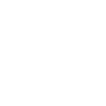
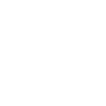























































































































































































            
            
            













</BODY>
<TIME>1454169600</TIME>
<DATE>2016-01-31</DATE>
<ID>79020760</ID>

<URL>http://mp.weixin.qq.com/s?__biz=MjM5MTUyMjQ2MA==&mid=402603428&idx=3&sn=affbe2b5c4777ff505ca2a014769f21c&scene=6#rd</URL>
<TITLE>������������������������������������������������������������������</TITLE>


















    








    


























































































































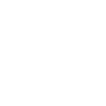

In [48]:
!head -n1000 ../wechat_data_medium/weixin_page_test

Looks like this dataset has quite not a standard format, where each "column" is encoded in new line as XML tag, and there is a newline between each record. I'm going to try to parse it by looking at <URL> tag.

In [49]:
with open("../wechat_data_medium/weixin_page_test", encoding='UTF-8') as f:
    pages = f.read()

In [50]:
pages = list(map(lambda p: '<URL>' + p, pages.split("<URL>")[1:]))

In [51]:
import re

DOCUMENT_PATTERN = re.compile("^<URL>(?P<url>.*)</URL>\n" +
         "<TITLE>(?P<title>.*)</TITLE>\n" +
         "<BODY>(?P<body>.*)</BODY>\n" +
         "<TIME>(?P<time>.*)</TIME>\n" + 
         "<DATE>(?P<date>.*)</DATE>\n" +
         "<ID>(?P<id>.*)</ID>\n+$", flags=re.DOTALL)

In [52]:
def parse_document(page):
    m = re.match(DOCUMENT_PATTERN, page)
    if m:
        return m.groupdict()
    else:
        raise Exception("Couldn't parse!")

In [54]:
import pandas as pd

pages_df = pd.DataFrame(list(map(parse_document, pages)))
pages_df['date'] = pd.to_datetime(pages_df.date)
pages_df['time'] = pd.to_datetime(pages_df.time, unit='s')
pages_df.sample(10)

body       date        id  \
11373  <!DOCTYPE html>\n<html>\n    <head>\n        <... 2016-01-31  79032132   
2442   <!DOCTYPE html>\n<html>\n    <head>\n        <... 2016-01-31  79023201   
8710   <!DOCTYPE html>\n<html>\n    <head>\n        <... 2016-01-31  79029469   
628    <!DOCTYPE html>\n<html>\n    <head>\n        <... 2016-01-31  79021387   
192    <!DOCTYPE html>\n<html>\n    <head>\n        <... 2016-01-31  79020951   
9341   <!DOCTYPE html>\n<html>\n    <head>\n        <... 2016-01-31  79030100   
13604  <!DOCTYPE html>\n<html>\n    <head>\n        <... 2016-01-31  79034363   
1827   <!DOCTYPE html>\n<html>\n    <head>\n        <... 2016-01-31  79022586   
9153   <!DOCTYPE html>\n<html>\n    <head>\n        <... 2016-01-31  79029912   
12632  <!DOCTYPE html>\n<html>\n    <head>\n        <... 2016-01-31  79033391   

                     time                                              title  \
11373 2016-01-30 19:23:17                                    城区划定四处烟花爆竹临时经营区   
2442  2016-01-30 16:14:42                                      人人都有痛苦，宽容就是忘却   
8710  2016-01-30 18:22:53                         小学应用题宝典！类型归纳+解题思路+例题整理，收藏！   
628   2016-01-30 16:02:33                                 一分钟读心术，让你一秒成为心理专家！   
192   2016-01-30 16:00:47                           临近年关各行涨声四起，看看大嵊州哪些行业必涨价！   
9341  2016-01-30 18:37:34  重庆方言&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;...   
13604 2016-01-30 20:17:28                                春节出游、回家不堵车，可以走这条高速！   
1827  2016-01-30 16:09:38                                 见过豪车，见过那么豪华的摩托车吗？！   
9153  2016-01-30 18:33:28                                       好校长必须具备的管理意识   
12632 2016-01-30 19:52:18                                      上海名媛，她如何美了一世！   

                                                     url  
11373  http://mp.weixin.qq.com/s?__biz=MzA5MzM5Mjg5MA...  
2442   http://mp.weixin.qq.com/s?__biz=MjM5OTEyODA2Mw...  
8710   http://mp.weixin.qq.com/s?__biz=MjM5Mjg1MDQ0OQ...  
628    http://mp.weixin.qq.com/s?__biz=MzA3NjQ0Njk0MA...  
192    http://mp.weixin.qq.com/s?__biz=MzA5NzA3OTQzMA...  
9341   http://mp.weixin.qq.com/s?__biz=MzAxNTUzOTU3Nw...  
13604  http://mp.weixin.qq.com/s?__biz=MzA3MzI5NzQyNQ...  
1827   http://mp.weixin.qq.com/s?__biz=MzI5NzA5ODIzOQ...  
9153   http://mp.weixin.qq.com/s?__biz=MzAxMTAzNTEzNA...  
12632  http://mp.weixin.qq.com/s?__biz=MjM5ODAzODgwMg...

Let's run a quick EDA on body, title, date and url

In [55]:
pages_df.title.str.len().describe()

count    13796.000000
mean        22.369092
std         10.584357
min          2.000000
25%         16.000000
50%         21.000000
75%         26.000000
max        292.000000
Name: title, dtype: float64

In [56]:
pages_df[pages_df.title.str.len() > 50].head(5)

body       date        id  \
45   <!DOCTYPE html>\n<html>\n    <head>\n        <... 2016-01-31  79020804   
49   <!DOCTYPE html>\n<html>\n    <head>\n        <... 2016-01-31  79020808   
60   <!DOCTYPE html>\n<html>\n    <head>\n        <... 2016-01-31  79020819   
146  <!DOCTYPE html>\n<html>\n    <head>\n        <... 2016-01-31  79020905   
206  <!DOCTYPE html>\n<html>\n    <head>\n        <... 2016-01-31  79020965   

                   time                                              title  \
45  2016-01-30 16:00:11  【福利】招财狗：0撸无限，填写邀请码得2元，邀请一个2元，每天签到2元，可充电话费、提现银行...   
49  2016-01-30 16:00:11  【居家首选：民丰小区】&nbsp;110㎡&nbsp;&nbsp;三室二厅&nbsp;精装修...   
60  2016-01-30 16:00:14  西班牙鞋履设计大师&nbsp;Manolo&nbsp;Blahnik&nbsp;纪录片《Ma...   
146 2016-01-30 16:00:36  湘乡时政︱市政府党组召开“三严三实”专题民主生活会&nbsp;&nbsp;;市关工委受助学生...   
206 2016-01-30 16:00:50  【V-BAR】V-BAR&nbsp;2周年庆典盛宴香港明星袁洁仪小姐、婚纱主题Party现场...   

                                                   url  
45   http://mp.weixin.qq.com/s?__biz=MzA3NTI3OTA4Mw...  
49   http://mp.weixin.qq.com/s?__biz=MzAxNTYxNjE1Nw...  
60   http://mp.weixin.qq.com/s?__biz=MjM5MTYwNjA0MQ...  
146  http://mp.weixin.qq.com/s?__biz=MzA4MjYyNzYzNg...  
206  http://mp.weixin.qq.com/s?__biz=MzA4NjIxNDkzOQ...

In [57]:
pages_df['clean_title'] = pages_df.title.map(double_unescape_html_text)

In [58]:
pages_df.clean_title.str.len().describe()

count    13796.000000
mean        21.078718
std          8.381656
min          2.000000
25%         15.000000
50%         20.000000
75%         25.000000
max         70.000000
Name: clean_title, dtype: float64

In [59]:
pages_df.clean_title.isnull().sum()

0

In [60]:
%matplotlib inline

pages_df.time.describe()

count                   13796
unique                   4575
top       2016-01-30 18:13:38
freq                       26
first     2016-01-30 16:00:00
last      2016-01-30 20:21:40
Name: time, dtype: object

In [61]:
pages_df.date.describe()

count                   13796
unique                      1
top       2016-01-31 00:00:00
freq                    13796
first     2016-01-31 00:00:00
last      2016-01-31 00:00:00
Name: date, dtype: object

In [62]:
pages_df.url.sample(10).values

array(['http://mp.weixin.qq.com/s?__biz=MzA4NDU5Nzg3NQ==&mid=401914571&idx=7&sn=bf3e1ef6cd4be1edfc7d3cd16ffc50f9&scene=6#rd',
       'http://mp.weixin.qq.com/s?__biz=MzA4NTMxODg5Mg==&mid=402467678&idx=2&sn=831c15deba1b4cbbf65ad3dbde14e650&scene=6#rd',
       'http://mp.weixin.qq.com/s?__biz=MzA4MDYyNzQyNg==&mid=401291030&idx=4&sn=ab0c70a1d9107fd98e67cd975e393d66&scene=6#rd',
       'http://mp.weixin.qq.com/s?__biz=MzAwOTEwMjA4Nw==&mid=401635961&idx=6&sn=4645f37cdca14399deb5d1f3ee38a235&scene=6#rd',
       'http://mp.weixin.qq.com/s?__biz=MzAxOTY5OTEyMg==&mid=417691203&idx=6&sn=7073a8099f3e3966064e7ce37e10da84&scene=6#rd',
       'http://mp.weixin.qq.com/s?__biz=MzAwMDI2MjU1Ng==&mid=401890372&idx=3&sn=f5a29703cfb88f35f57decd641c4665b&scene=6#rd',
       'http://mp.weixin.qq.com/s?__biz=MzA4MzcxNTcwMg==&mid=403280062&idx=1&sn=367345f872f8a98dea7d2942aa49f8e8&scene=6#rd',
       'http://mp.weixin.qq.com/s?__biz=MzAxNzE2MzAyMg==&mid=401182824&idx=3&sn=d65f89170dba204126c2df12f560b462&scene

Let's extract biz from URL

In [63]:
ARTICLE_URL_PATTERN = r"^http://.*?__biz=(?P<biz>.*)&mid.*$"

In [64]:
def extract_biz_from_url(url):
    m = re.match(ARTICLE_URL_PATTERN, url)
    if m:
        return m.groupdict()['biz']
    else:
        raise Exception("Incorrect URL!")
        


In [65]:
pages_df['biz_id'] = pages_df.url.map(extract_biz_from_url)
pages_df.head()

body       date        id  \
0  <!DOCTYPE html>\n<html>\n    <head>\n        <... 2016-01-31  79020759   
1  <!DOCTYPE html>\n<html>\n    <head>\n        <... 2016-01-31  79020760   
2  <!DOCTYPE html>\n<html>\n    <head>\n        <... 2016-01-31  79020761   
3  <!DOCTYPE html>\n<html>\n    <head>\n        <... 2016-01-31  79020762   
4  <!DOCTYPE html>\n<html>\n    <head>\n        <... 2016-01-31  79020763   

                 time                                      title  \
0 2016-01-30 16:00:00  关注&nbsp;|&nbsp;“寨卡”病毒中南美洲迅速蔓延&nbsp;巴西蒙上阴影   
1 2016-01-30 16:00:00                        ㊙身为一个小姐，不能有感觉了再接客……   
2 2016-01-30 16:00:00                     两次战败，被揍的稀巴烂的德国为何能迅速崛起？   
3 2016-01-30 16:00:00                                 一个老炮儿的无奈抗争   
4 2016-01-30 16:00:00                               秘一个女子该有的精致生活   

                                                 url  \
0  http://mp.weixin.qq.com/s?__biz=MjM5OTE5MzE4Mg...   
1  http://mp.weixin.qq.com/s?__biz=MjM5ODE2Mjk1Nw...   
2  http://mp.weixin.qq.com/s?__biz=MjM5MTUyMjQ2MA...   
3  http://mp.weixin.qq.com/s?__biz=MzA3MDU3MDc2Mw...   
4  http://mp.weixin.qq.com/s?__biz=MzA3MzUwOTQwNg...   

                  clean_title            biz_id  
0  关注 | “寨卡”病毒中南美洲迅速蔓延 巴西蒙上阴影  MjM5OTE5MzE4Mg==  
1         ㊙身为一个小姐，不能有感觉了再接客……  MjM5ODE2Mjk1Nw==  
2      两次战败，被揍的稀巴烂的德国为何能迅速崛起？  MjM5MTUyMjQ2MA==  
3                  一个老炮儿的无奈抗争  MzA3MDU3MDc2Mw==  
4                秘一个女子该有的精致生活  MzA3MzUwOTQwNg==

Let's check the distribution of extracted `biz_id` to understand if there is any skeweness

In [66]:
pages_df.biz_id.value_counts().head(10)

MjM5NjE5MTY1Mg==    8
MzAxNDA2MDQxMw==    7
MzA4ODMwMjEzNg==    7
MzAwNDAzNDI3OA==    7
MzA4ODI4OTczNQ==    7
MjM5NjcyNTc2NA==    7
MzA3NDkxNDIyMQ==    6
MjM5Njk0OTUyMg==    6
MjM5MzYwNDY4MQ==    6
MzA5Njc2MzEzNw==    6
Name: biz_id, dtype: int64

It looks like there is little skeweness. That's good.

Let's check if every biz_id is in the biz dataset

In [67]:
(~pages_df.biz_id.isin(biz.biz_id)).sum()

961

Looks like 961 records don't match. Why is that?

In [68]:
pages_missing_biz_ids = pages_df[~pages_df.biz_id.isin(biz.biz_id)]
pages_missing_biz_ids.head()

body       date        id  \
6   <!DOCTYPE html>\n<html>\n    <head>\n        <... 2016-01-31  79020765   
13  <!DOCTYPE html>\n<html>\n    <head>\n        <... 2016-01-31  79020772   
30  <!DOCTYPE html>\n<html>\n    <head>\n        <... 2016-01-31  79020789   
46  <!DOCTYPE html>\n<html>\n    <head>\n        <... 2016-01-31  79020805   
56  <!DOCTYPE html>\n<html>\n    <head>\n        <... 2016-01-31  79020815   

                  time                      title  \
6  2016-01-30 16:00:01          说说德国教育牛在哪里？（好文推荐）   
13 2016-01-30 16:00:03          【大话青县·精选】出售帝豪小区楼房   
30 2016-01-30 16:00:07            【关注】呼市一小区居民家中着火   
46 2016-01-30 16:00:11            ?马云大军出动，迅速占领日本！   
56 2016-01-30 16:00:14  红木行业一片惨烈&nbsp;为何她却快速开店增长？   

                                                  url           clean_title  \
6   http://mp.weixin.qq.com/s?__biz=MjM5OTc1NTU5OQ...     说说德国教育牛在哪里？（好文推荐）   
13  http://mp.weixin.qq.com/s?__biz=MjM5NTM5NTIxMQ...     【大话青县·精选】出售帝豪小区楼房   
30  http://mp.weixin.qq.com/s?__biz=MjM5NDY5MDgyOQ...       【关注】呼市一小区居民家中着火   
46  http://mp.weixin.qq.com/s?__biz=MzA3MTY3OTgzOA...       ?马云大军出动，迅速占领日本！   
56  http://mp.weixin.qq.com/s?__biz=MjM5ODU0Njc2MQ...  红木行业一片惨烈 为何她却快速开店增长？   

              biz_id  
6   MjM5OTc1NTU5OQ==  
13  MjM5NTM5NTIxMQ==  
30  MjM5NDY5MDgyOQ==  
46  MzA3MTY3OTgzOA==  
56  MjM5ODU0Njc2MQ==

In [69]:
pages_missing_biz_ids.biz_id.value_counts().head()

MjM5NDMzNTk2MA==    6
MjM5NzI3MTM3OA==    6
MzA3MzMzNDk2NA==    6
MjM5MzYwNDY4MQ==    6
MjM5Njc3MzU2MQ==    5
Name: biz_id, dtype: int64

In [70]:
biz[biz.biz_id.fillna('').str.contains('MjM5OTc1NTU5OQ==')]

Empty DataFrame
Columns: [id, biz_id, biz_name, biz_code, biz_description, qr_code, timestamp, clean_biz_name, clean_biz_description]
Index: []

Let's leave it for now

> Within the content is a javascript variable “ct” that denotes publish time

Let's check it

In [71]:
def show_text_around_var_ct(text):
    i = text.index("var ct")
    return text[i-10:i+50]

for i in range(10):
    print(show_text_around_var_ct(pages_df.body.sample(10).iloc[i]))

9";
      var ct = "1454158835";
      var user_name = "gh_2
9";
      var ct = "1454162330";
      var user_name = "gh_6
9";
      var ct = "1454137078";
      var user_name = "gh_2
9";
      var ct = "1454141418";
      var user_name = "gh_c
9";
      var ct = "1454169632";
      var user_name = "gh_7
9";
      var ct = "1454170097";
      var user_name = "gh_2
9";
      var ct = "1454161089";
      var user_name = "gh_6
9";
      var ct = "1454169693";
      var user_name = "gh_f
9";
      var ct = "1454167188";
      var user_name = "gh_f
9";
      var ct = "1454170632";
      var user_name = "gh_3


Looks like we can create a regex for extracting this timestamp

In [72]:
PUBLISH_TIMESTAMP_PATTERN = r"var ct = \"(?P<ct>\d+)\";"

def extract_publish_time_from_body(body):
    cts = re.findall(PUBLISH_TIMESTAMP_PATTERN, body)
    if len(cts) != 1:
        raise Exception("Incorrect number of publish times in body!")
    return int(cts[0])

In [73]:
pages_df['publish_time'] = pd.to_datetime(pages_df.body.map(extract_publish_time_from_body), unit='s')

In [74]:
pages_df.head()

body       date        id  \
0  <!DOCTYPE html>\n<html>\n    <head>\n        <... 2016-01-31  79020759   
1  <!DOCTYPE html>\n<html>\n    <head>\n        <... 2016-01-31  79020760   
2  <!DOCTYPE html>\n<html>\n    <head>\n        <... 2016-01-31  79020761   
3  <!DOCTYPE html>\n<html>\n    <head>\n        <... 2016-01-31  79020762   
4  <!DOCTYPE html>\n<html>\n    <head>\n        <... 2016-01-31  79020763   

                 time                                      title  \
0 2016-01-30 16:00:00  关注&nbsp;|&nbsp;“寨卡”病毒中南美洲迅速蔓延&nbsp;巴西蒙上阴影   
1 2016-01-30 16:00:00                        ㊙身为一个小姐，不能有感觉了再接客……   
2 2016-01-30 16:00:00                     两次战败，被揍的稀巴烂的德国为何能迅速崛起？   
3 2016-01-30 16:00:00                                 一个老炮儿的无奈抗争   
4 2016-01-30 16:00:00                               秘一个女子该有的精致生活   

                                                 url  \
0  http://mp.weixin.qq.com/s?__biz=MjM5OTE5MzE4Mg...   
1  http://mp.weixin.qq.com/s?__biz=MjM5ODE2Mjk1Nw...   
2  http://mp.weixin.qq.com/s?__biz=MjM5MTUyMjQ2MA...   
3  http://mp.weixin.qq.com/s?__biz=MzA3MDU3MDc2Mw...   
4  http://mp.weixin.qq.com/s?__biz=MzA3MzUwOTQwNg...   

                  clean_title            biz_id        publish_time  
0  关注 | “寨卡”病毒中南美洲迅速蔓延 巴西蒙上阴影  MjM5OTE5MzE4Mg== 2016-01-30 15:01:21  
1         ㊙身为一个小姐，不能有感觉了再接客……  MjM5ODE2Mjk1Nw== 2016-01-30 15:11:35  
2      两次战败，被揍的稀巴烂的德国为何能迅速崛起？  MjM5MTUyMjQ2MA== 2016-01-30 15:12:37  
3                  一个老炮儿的无奈抗争  MzA3MDU3MDc2Mw== 2016-01-30 15:12:25  
4                秘一个女子该有的精致生活  MzA3MzUwOTQwNg== 2016-01-30 15:11:05

In [75]:
pages_df.publish_time.describe()

count                   13796
unique                   7774
top       2016-01-30 16:00:32
freq                       28
first     2016-01-29 16:20:30
last      2016-01-30 19:51:46
Name: publish_time, dtype: object

In [76]:
pages_df.url.value_counts().head()

http://mp.weixin.qq.com/s?__biz=MzAwNDM1MTY3OA==&mid=402063769&idx=1&sn=66bb4c4a4b0c3587f5b6bfd6d11f8433&scene=6#rd    1
http://mp.weixin.qq.com/s?__biz=MzAwMjI0NTM0Mg==&mid=403058454&idx=2&sn=4c23f8ec05a900f44e21df013bc1e05e&scene=6#rd    1
http://mp.weixin.qq.com/s?__biz=MzA5OTA0NDc2MA==&mid=401920276&idx=5&sn=045491f7317bca20c7ae86774dc0e6b2&scene=6#rd    1
http://mp.weixin.qq.com/s?__biz=MzA5NTk3NzczMQ==&mid=401425375&idx=2&sn=1a7c54f766496785f0a6d938f38727c9&scene=6#rd    1
http://mp.weixin.qq.com/s?__biz=MzA5NTEyMjIzOA==&mid=401144404&idx=1&sn=5b6458d74cea8f870880adc791267337&scene=6#rd    1
Name: url, dtype: int64

### Extract content without HTML

/Users/mateusz/.virtualenvs/deep-learning-with-python/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


<!DOCTYPE html>
<html>
<head>
<script type="text/javascript">
            window.logs = {
                pagetime: {}
            };
            window.logs.pagetime['html_begin'] = (+new Date());
        </script>
<script type="text/javascript"> 
    var page_begintime = (+new Date());

    var biz = "MjM5OTE5MzE4Mg==";
    var sn = "1ba7d9edfd708ae64df7b31b662b1b59" || "";
    var mid = "403624174" || "";
    var idx = "4" || "" ;
    
    
    var is_rumor = ""*1;
    var norumor = ""*1;
    if (!!is_rumor&&!norumor){
      if (!document.referrer || document.referrer.indexOf("mp.weixin.qq.com/mp/rumor") == -1){
        location.href = "http://mp.weixin.qq.com/mp/rumor?action=info&__biz=" + biz + "&mid=" + mid + "&idx=" + idx + "&sn=" + sn + "#wechat_redirect";
      }
    }

    
    
</script>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta content="width=device-width,initial-scale=1.0,maximum-scale=
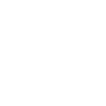

In [78]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(pages_df.body.iloc[0])
soup

Depending on how we define "raw conent, we might want to extract different things. I'm going to assume that content is raw text inside whole body. Alternative would be to extract div with class `rich_media_content`.

In [79]:
def extract_text_content(body):
    soup = BeautifulSoup(body)
    [s.extract() for s in soup('script')]
    return soup.body.text

In [80]:
extract_text_content(pages_df.body.iloc[0])

/Users/mateusz/.virtualenvs/deep-learning-with-python/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


'\n\n\n\n关注 | “寨卡”病毒中南美洲迅速蔓延\xa0巴西蒙上阴影\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n提交\n\n\n我的留言\n\n\n\n\n\n加载中\n\n\n\n已留言\n\n\n\n\n\n\n\n\n\n\n                        关注 | “寨卡”病毒中南美洲迅速蔓延\xa0巴西蒙上阴影 \n                    \n\n2016-01-30\n法国侨报\n法国侨报\n\n\n法国侨报\n\n\n微信号\necmdpress\n\n\n功能介绍\n关注《法国侨报》微信平台，即时获取您身边最新、最快的新闻时事，抢先知晓华侨华人动态。侨报竭力为您服务，关注世界，关注法国，关注华侨华人，关注《法国侨报》。\n\n\n\n\n\n\n\n\n\n请点右上方“…”，点击“发送给朋友”或“分享到朋友圈”，分享法国生活、巴黎时尚1月29日消息，“寨卡热”疫情在中南美洲迅速蔓延，欧洲多国也相继出现确诊个案。世界卫生组织(WHO)28日举行特别会议，总干事陈冯富珍指，寨卡病毒正在“爆炸性扩散”，可能会在美洲感染300万至400万人。她表示，尽管未确切证明寨卡热与初生婴儿小头症有关，但“风险水平极高”。\xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0据中新网报道法国侨网推广本期责任编辑：壹贰叁您的喜欢是我们最大的动力，如果觉得还不错，请点一下下方大拇指点赞，也欢迎在下方“写留言”处发表您的看法！谢谢！您的支持和鼓励是我们前进的动力！更多内容请点击左下角“阅读原文”，访问“法国侨网”\xa0↓↓↓\n\n\n\n\n阅读 \n\n\n\n举报\n\n\n\n\n\n\n\n\n\n精选留言\n\n关注该公众号可参与留言\n\n写留言\n\n

In [81]:
extract_text_content(pages_df.body.iloc[1])

/Users/mateusz/.virtualenvs/deep-learning-with-python/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


'\n\n\n\n㊙身为一个小姐，不能有感觉了再接客……\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n提交\n\n\n我的留言\n\n\n\n\n\n加载中\n\n\n\n已留言\n\n\n\n\n\n\n\n\n\n\n                        ㊙身为一个小姐，不能有感觉了再接客…… \n                    \n\n2016-01-30\n我爱服装搭配\n我爱服装搭配\n\n\n我爱服装搭配\n\n\n微信号\ndapei522\n\n\n功能介绍\n服装搭配小知识，提升自身魅力哦\n\n\n\n\n\n\n\n\n\n作为一个小姐，你不能有了感觉才开门接客。作为一个作家，你不能有了灵感才动笔写作。作为一个员工，你不能有心情了才开始工作。人生如妓，努力达到角色与体验的高度统一，才是正道。骑自行车，再努力也追不上路虎。说明：平台很重要!男人，再优秀，没女人也生不下孩子。说明：合作很重要！一个人，再有能力，也干不过一群人。说明：团队很重要！想有保障，买再大的水桶都不如挖一口井。说明：渠道很重要！两只青蛙相爱，婚后生一癞蛤蟆。公青蛙见状大怒：怎么回事？母青蛙哭着说：他爹，认识你之前我整过容。说明：了解很重要！小驴问老驴：为啥咱们天天吃草，而奶牛顿顿精饲料？老驴叹道：咱爷们靠腿吃饭，人家靠胸脯吃饭。说明：心态很重要！鸭子与螃蟹赛跑难分胜负，裁判说：你们划拳确定吧！鸭子大怒：我出的全是布，他总是剪刀。说明：先天很重要！狗对熊说：嫁给我吧，你会幸福的。熊说：嫁你生狗熊，我要嫁给猫，生熊猫才尊贵。说明：选择很重要！跟着苍蝇找厕所，跟着蜜蜂找花朵，跟着富翁挣百万，跟着乞丐会要饭！现实生活中，你和谁在一起的确很重要，甚至能改变你的成长轨迹，决定你的人生成败。和什么样的人在一起，就会有什么样的人生。和勤奋的人在一起，你不会懒惰；和积极的人在一起，你不会消沉；与智者同行，你会不同凡响；与高人为伍，你能登上巅峰。科学家研究认为：人是唯一能接受暗示的动物。积极的暗示，会对人的情绪和生理状态产生良好的影响，激发人的内在潜能，发挥人的超常水平，使人进取，催人奋进。远离消极的人吧!否则，他们会在不知不觉中偷走你的梦想，使你渐渐颓废，变得平庸。积极的人像太阳，照到哪里哪里亮；消极的人像月亮，初一十五不一样。

In [82]:
pages_df['raw_content'] = pages_df.body.map(extract_text_content)

/Users/mateusz/.virtualenvs/deep-learning-with-python/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [83]:
pages_df.head()

body       date        id  \
0  <!DOCTYPE html>\n<html>\n    <head>\n        <... 2016-01-31  79020759   
1  <!DOCTYPE html>\n<html>\n    <head>\n        <... 2016-01-31  79020760   
2  <!DOCTYPE html>\n<html>\n    <head>\n        <... 2016-01-31  79020761   
3  <!DOCTYPE html>\n<html>\n    <head>\n        <... 2016-01-31  79020762   
4  <!DOCTYPE html>\n<html>\n    <head>\n        <... 2016-01-31  79020763   

                 time                                      title  \
0 2016-01-30 16:00:00  关注&nbsp;|&nbsp;“寨卡”病毒中南美洲迅速蔓延&nbsp;巴西蒙上阴影   
1 2016-01-30 16:00:00                        ㊙身为一个小姐，不能有感觉了再接客……   
2 2016-01-30 16:00:00                     两次战败，被揍的稀巴烂的德国为何能迅速崛起？   
3 2016-01-30 16:00:00                                 一个老炮儿的无奈抗争   
4 2016-01-30 16:00:00                               秘一个女子该有的精致生活   

                                                 url  \
0  http://mp.weixin.qq.com/s?__biz=MjM5OTE5MzE4Mg...   
1  http://mp.weixin.qq.com/s?__biz=MjM5ODE2Mjk1Nw...   
2  http://mp.weixin.qq.com/s?__biz=MjM5MTUyMjQ2MA...   
3  http://mp.weixin.qq.com/s?__biz=MzA3MDU3MDc2Mw...   
4  http://mp.weixin.qq.com/s?__biz=MzA3MzUwOTQwNg...   

                  clean_title            biz_id        publish_time  \
0  关注 | “寨卡”病毒中南美洲迅速蔓延 巴西蒙上阴影  MjM5OTE5MzE4Mg== 2016-01-30 15:01:21   
1         ㊙身为一个小姐，不能有感觉了再接客……  MjM5ODE2Mjk1Nw== 2016-01-30 15:11:35   
2      两次战败，被揍的稀巴烂的德国为何能迅速崛起？  MjM5MTUyMjQ2MA== 2016-01-30 15:12:37   
3                  一个老炮儿的无奈抗争  MzA3MDU3MDc2Mw== 2016-01-30 15:12:25   
4                秘一个女子该有的精致生活  MzA3MzUwOTQwNg== 2016-01-30 15:11:05   

                                         raw_content  
0  \n\n\n\n关注 | “寨卡”病毒中南美洲迅速蔓延 巴西蒙上阴影\n\n\n\n\n\n...  
1  \n\n\n\n㊙身为一个小姐，不能有感觉了再接客……\n\n\n\n\n\n\n\n\n\...  
2  \n\n\n\n两次战败，被揍的稀巴烂的德国为何能迅速崛起？\n\n\n\n\n\n\n\n...  
3  \n\n\n\n一个老炮儿的无奈抗争\n\n\n\n\n\n\n\n\n\n\n\n\n\n...  
4  \n\n\n\n秘一个女子该有的精致生活\n\n\n\n\n\n\n\n\n\n\n\n\n...

In [84]:
pages_df.to_pickle('pages-parsed.pickle')

## Checking clicks

In [85]:
!head -n100  ../wechat_data_medium/weixin_click

54305043	http://mp.weixin.qq.com/s?__biz=MjM5OTk0NTMwMA==&mid=401622306&idx=1&sn=c61368facc3e0aee69175a50bf5c8c25&scene=6#rd	������������������������������������������������������������	0	0	1454169600	2016-01-31
54305044	http://mp.weixin.qq.com/s?__biz=MzA3MzMxMzkwOA==&mid=402795157&idx=6&sn=46df1ae59c5db25aa15fd71bcf28caa0&scene=6#rd	������180���������������������������������������������������������������������������������������������	0	0	1454169600	2016-01-31
54305045	http://mp.weixin.qq.com/s?__biz=MjM5OTE5MzE4Mg==&mid=403624174&idx=4&sn=1ba7d9edfd708ae64df7b31b662b1b59&scene=6#rd	������&nbsp;|&nbsp;������������������������������������������&nbsp;������������������	33	0	1454169600	2016-01-31
54305046	http://mp.weixin.qq.com/s?__biz=MjM5ODE2Mjk1Nw==&mid=401867851&idx=2&sn=1a7d4f2ea9bf962229c702dfe664522c&scene=6#rd	���������������������������������������������������������	910	4	1454169600	2016-01-31
54305047	http://mp.weixin.qq.com/s?__biz=MjM5MTUyMjQ2MA==&mid=402603428&idx=3&sn=affb

54305105	http://mp.weixin.qq.com/s?__biz=MjM5MTYwNjA0MQ==&mid=402079404&idx=5&sn=887deec42f10ba31ad68b91c25bb09bb&scene=6#rd	���������������������������&nbsp;Manolo&nbsp;Blahnik&nbsp;������������Manolo���������������������	323	0	1454169614	2016-01-31
54305106	http://mp.weixin.qq.com/s?__biz=MzA3NDc1NDA5MQ==&mid=1100606957&idx=4&sn=633618795686a459a805fd7bda306615&scene=6#rd	������������������2���	9	0	1454169615	2016-01-31
54305107	http://mp.weixin.qq.com/s?__biz=MzAwODAzODQ3Nw==&mid=403771280&idx=3&sn=f76af46a704f800843d64324078bd4fc&scene=6#rd	������������������������������������������������������������������	3	0	1454169615	2016-01-31
54305108	http://mp.weixin.qq.com/s?__biz=MjM5MTE5NDEwMQ==&mid=401457184&idx=1&sn=6f1a79234022ce26c0a0affcf30b9cd9&scene=6#rd	������������������������������������������������������������������	12	0	1454169615	2016-01-31
54305109	http://mp.weixin.qq.com/s?__biz=MjM5ODg4Nzk4Mg==&mid=402059511&idx=3&sn=3e836dcf4c4943a68652bc71b2801861&scene=6#rd	������������

In [86]:
clicks = pd.read_table(open("../wechat_data_medium/weixin_click", 'r',  encoding='utf-8', errors='replace'), names=[
    'id',
    'url',
    'title',
    'read_number',
    'like_number',
    'timestamp',
    'date',
], low_memory=False, index_col=False)

clicks['timestamp'] = pd.to_datetime(clicks.timestamp, unit='s')
clicks['date'] = pd.to_datetime(clicks.date)

clicks.head()

id                                                url  \
0  54305043  http://mp.weixin.qq.com/s?__biz=MjM5OTk0NTMwMA...   
1  54305044  http://mp.weixin.qq.com/s?__biz=MzA3MzMxMzkwOA...   
2  54305045  http://mp.weixin.qq.com/s?__biz=MjM5OTE5MzE4Mg...   
3  54305046  http://mp.weixin.qq.com/s?__biz=MjM5ODE2Mjk1Nw...   
4  54305047  http://mp.weixin.qq.com/s?__biz=MjM5MTUyMjQ2MA...   

                                       title  read_number  like_number  \
0                       到了夏威夷～才知道女人，可以不必买胸罩！            0            0   
1       每年180万人因喝酒而死亡，你知道酒后都有哪些事不宜做么？为自己为亲人。            0            0   
2  关注&nbsp;|&nbsp;“寨卡”病毒中南美洲迅速蔓延&nbsp;巴西蒙上阴影           33            0   
3                        ㊙身为一个小姐，不能有感觉了再接客……          910            4   
4                     两次战败，被揍的稀巴烂的德国为何能迅速崛起？          426            6   

            timestamp       date  
0 2016-01-30 16:00:00 2016-01-31  
1 2016-01-30 16:00:00 2016-01-31  
2 2016-01-30 16:00:00 2016-01-31  
3 2016-01-30 16:00:00 2016-01-31  
4 2016-01-30 16:00:00 2016-01-31

In [87]:
clicks.shape

(308495, 7)

In [88]:
clicks['clean_title'] = clicks.title.map(double_unescape_html_text)
clicks.head()

id                                                url  \
0  54305043  http://mp.weixin.qq.com/s?__biz=MjM5OTk0NTMwMA...   
1  54305044  http://mp.weixin.qq.com/s?__biz=MzA3MzMxMzkwOA...   
2  54305045  http://mp.weixin.qq.com/s?__biz=MjM5OTE5MzE4Mg...   
3  54305046  http://mp.weixin.qq.com/s?__biz=MjM5ODE2Mjk1Nw...   
4  54305047  http://mp.weixin.qq.com/s?__biz=MjM5MTUyMjQ2MA...   

                                       title  read_number  like_number  \
0                       到了夏威夷～才知道女人，可以不必买胸罩！            0            0   
1       每年180万人因喝酒而死亡，你知道酒后都有哪些事不宜做么？为自己为亲人。            0            0   
2  关注&nbsp;|&nbsp;“寨卡”病毒中南美洲迅速蔓延&nbsp;巴西蒙上阴影           33            0   
3                        ㊙身为一个小姐，不能有感觉了再接客……          910            4   
4                     两次战败，被揍的稀巴烂的德国为何能迅速崛起？          426            6   

            timestamp       date                           clean_title  
0 2016-01-30 16:00:00 2016-01-31                  到了夏威夷～才知道女人，可以不必买胸罩！  
1 2016-01-30 16:00:00 2016-01-31  每年180万人因喝酒而死亡，你知道酒后都有哪些事不宜做么？为自己为亲人。  
2 2016-01-30 16:00:00 2016-01-31            关注 | “寨卡”病毒中南美洲迅速蔓延 巴西蒙上阴影  
3 2016-01-30 16:00:00 2016-01-31                   ㊙身为一个小姐，不能有感觉了再接客……  
4 2016-01-30 16:00:00 2016-01-31                两次战败，被揍的稀巴烂的德国为何能迅速崛起？

Let's check those duplicated entries.

In [89]:
clicks.url.value_counts().head()

http://mp.weixin.qq.com/s?__biz=MjM5MTMwMTI3NA==&mid=403745393&idx=4&sn=2914fcd0359e3b6bc67faaf987e521f7&scene=6#rd    22
http://mp.weixin.qq.com/s?__biz=MzAwNzU5MTAxNw==&mid=403315080&idx=1&sn=dd35486fc99fa545e7cd077c62acf7ff&scene=6#rd    22
http://mp.weixin.qq.com/s?__biz=MzA3ODI0NzU4OQ==&mid=404248127&idx=1&sn=2fd8eb67b833ff0230154a90ff2f1bdd&scene=6#rd    22
http://mp.weixin.qq.com/s?__biz=MjM5MjgxOTEzOA==&mid=402731812&idx=4&sn=eaaf422e0e8dc0c3396b874af57726d6&scene=6#rd    22
http://mp.weixin.qq.com/s?__biz=MzA5ODc2NDMwMQ==&mid=401169401&idx=3&sn=c67de6bd30171d671a340c692acedae1&scene=6#rd    22
Name: url, dtype: int64

In [90]:
clicks[clicks.url == clicks.url.value_counts().index[0]].head()

id                                                url  \
27447  54332490  http://mp.weixin.qq.com/s?__biz=MjM5MTMwMTI3NA...   
27448  54332491  http://mp.weixin.qq.com/s?__biz=MjM5MTMwMTI3NA...   
27449  54332492  http://mp.weixin.qq.com/s?__biz=MjM5MTMwMTI3NA...   
27450  54332493  http://mp.weixin.qq.com/s?__biz=MjM5MTMwMTI3NA...   
27451  54332494  http://mp.weixin.qq.com/s?__biz=MjM5MTMwMTI3NA...   

                          title  read_number  like_number           timestamp  \
27447  2000万社会精英关注的顶级新媒体，都在这里了！          347            1 2016-01-30 23:38:50   
27448  2000万社会精英关注的顶级新媒体，都在这里了！          347            1 2016-01-30 23:38:50   
27449  2000万社会精英关注的顶级新媒体，都在这里了！          347            1 2016-01-30 23:38:50   
27450  2000万社会精英关注的顶级新媒体，都在这里了！          347            1 2016-01-30 23:38:50   
27451  2000万社会精英关注的顶级新媒体，都在这里了！          347            1 2016-01-30 23:38:50   

            date               clean_title  
27447 2016-01-31  2000万社会精英关注的顶级新媒体，都在这里了！  
27448 2016-01-31  2000万社会精英关注的顶级新媒体，都在这里了！  
27449 2016-01-31  2000万社会精英关注的顶级新媒体，都在这里了！  
27450 2016-01-31  2000万社会精英关注的顶级新媒体，都在这里了！  
27451 2016-01-31  2000万社会精英关注的顶级新媒体，都在这里了！

Let's keep only those with maximum read_number

In [91]:
clicks_no_duplicates = clicks.sort_values('read_number', ascending=False).drop_duplicates(['url'])

In [92]:
clicks_no_duplicates.shape

(257749, 8)

In [93]:
clicks_no_duplicates.date.describe()

count                  257749
unique                      1
top       2016-01-31 00:00:00
freq                   257749
first     2016-01-31 00:00:00
last      2016-01-31 00:00:00
Name: date, dtype: object

In [94]:
clicks_no_duplicates.timestamp.describe()

count                  257749
unique                  57569
top       2016-01-31 12:56:22
freq                       25
first     2016-01-30 16:00:00
last      2016-01-31 15:59:59
Name: timestamp, dtype: object

In [95]:
clicks_no_duplicates.read_number.describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.999])

count    257749.000000
mean       1566.651665
std        5366.179613
min           0.000000
50%         227.000000
75%        1173.000000
90%        3432.000000
95%        6366.000000
99.9%     89144.984000
max      100001.000000
Name: read_number, dtype: float64

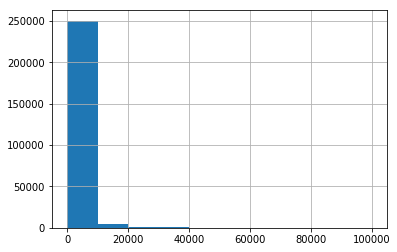

In [96]:
clicks_no_duplicates.read_number.hist()

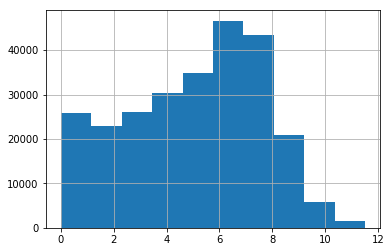

In [97]:
import numpy as np
clicks_no_duplicates.read_number.map(np.log1p).hist()

Looks like the distribution is sort of log normal, which is interesting. But probably we shouldn't treat extreme values as outliers.

In [98]:
clicks_no_duplicates[clicks_no_duplicates.read_number > 1200].sort_values('read_number', ascending=False).head()

id                                                url  \
93890   54398933  http://mp.weixin.qq.com/s?__biz=MjM5MjAxNDM4MA...   
15478   54320521  http://mp.weixin.qq.com/s?__biz=MzAwMDAyMzY3OA...   
171031  54476074  http://mp.weixin.qq.com/s?__biz=MjM5ODI3ODI4MA...   
125716  54430759  http://mp.weixin.qq.com/s?__biz=MjM5MDMyMzg2MA...   
299120  54604163  http://mp.weixin.qq.com/s?__biz=MjM5MjAxNDM4MA...   

                                title  read_number  like_number  \
93890         【提醒】吓一跳！据说10年后中国的房子将是这样       100001         1192   
15478              找个日本女孩做女朋友是什么样的体验？       100001          713   
171031  为什么“被追尾”还要负全责？警察叔叔说：因为你做了这些……       100001          126   
125716                  单身，会不会成为一种“病”       100001          391   
299120  【提醒】几个孩子瞬间被炸飞…路上随处可见的这个东西碰不得！       100001          389   

                 timestamp       date                    clean_title  
93890  2016-01-31 03:11:16 2016-01-31        【提醒】吓一跳！据说10年后中国的房子将是这样  
15478  2016-01-30 19:48:13 2016-01-31             找个日本女孩做女朋友是什么样的体验？  
171031 2016-01-31 07:28:07 2016-01-31  为什么“被追尾”还要负全责？警察叔叔说：因为你做了这些……  
125716 2016-01-31 04:51:59 2016-01-31                  单身，会不会成为一种“病”  
299120 2016-01-31 15:16:08 2016-01-31  【提醒】几个孩子瞬间被炸飞…路上随处可见的这个东西碰不得！

In [99]:
clicks_no_duplicates.like_number.describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.999])

count    257749.000000
mean          7.252498
std          74.825677
min           0.000000
50%           1.000000
75%           3.000000
90%          12.000000
95%          25.000000
99.9%       525.000000
max       15199.000000
Name: like_number, dtype: float64

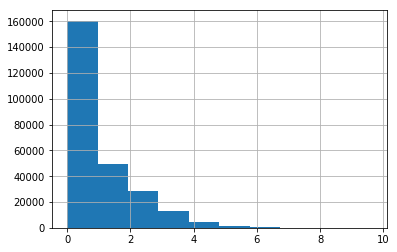

In [100]:
import numpy as np
clicks_no_duplicates.like_number.map(np.log1p).hist()

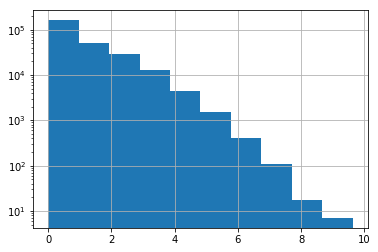

In [101]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
clicks_no_duplicates.like_number.map(np.log1p).hist(ax=ax)
ax.set_yscale('log')

Interesting, is it a Pareto distribution?

In [102]:
clicks_no_duplicates.sort_values('like_number', ascending=False).head()

id                                                url  \
162238  54467281  http://mp.weixin.qq.com/s?__biz=MzA5OTQyMDgyOQ...   
117727  54422770  http://mp.weixin.qq.com/s?__biz=MTgwNTE3Mjg2MA...   
250517  54555560  http://mp.weixin.qq.com/s?__biz=MTgwNTE3Mjg2MA...   
167375  54472418  http://mp.weixin.qq.com/s?__biz=MjM5OTIwODMzMQ...   
151397  54456440  http://mp.weixin.qq.com/s?__biz=MjM5OTIwODMzMQ...   

                              title  read_number  like_number  \
162238  2016年1月31日（星期日）三分钟新闻早餐（综合版）       100001        15199   
117727            【冷兔•槽】每日一冷NO.1056       100001        14441   
250517        【冷兔趣闻】女人心看不透，只因胸前肉太厚！       100001        11403   
167375        哈哈哈！再柔软的菊花，也抗不住这坚硬的雪花       100001        11104   
151397        哈哈哈！再柔软的菊花，也抗不住这坚硬的雪花       100001        10312   

                 timestamp       date                  clean_title  
162238 2016-01-31 06:50:59 2016-01-31  2016年1月31日（星期日）三分钟新闻早餐（综合版）  
117727 2016-01-31 04:26:01 2016-01-31            【冷兔•槽】每日一冷NO.1056  
250517 2016-01-31 12:13:09 2016-01-31        【冷兔趣闻】女人心看不透，只因胸前肉太厚！  
167375 2016-01-31 07:16:42 2016-01-31        哈哈哈！再柔软的菊花，也抗不住这坚硬的雪花  
151397 2016-01-31 06:16:10 2016-01-31        哈哈哈！再柔软的菊花，也抗不住这坚硬的雪花

Ok, I suppose that we should be able to join  this dataset with articles based on URL.

In [103]:
(~clicks_no_duplicates.url.isin(pages_df.url)).sum()

244265

Wow, that many don't match? 

What about the other way around?

In [104]:
(~pages_df.url.isin(clicks_no_duplicates.url)).sum()

312

Ok, so it seems that 312 articles don't have any click info? Let's check why that might be 

In [105]:
pages_missing_clicks = pages_df[(~pages_df.url.isin(clicks_no_duplicates.url))]
pages_missing_clicks.iloc[0].url

'http://mp.weixin.qq.com/s?__biz=MzA5NTQ1NDkxMw==&mid=401765553&idx=2&sn=33190232a856d6ee4f791d91b565c709&scene=6#rd'

In [106]:
clicks_no_duplicates[clicks_no_duplicates.url.str.contains('MzA5NTQ1NDkxMw==')].url.values

array(['http://mp.weixin.qq.com/s?__biz=MzA5NTQ1NDkxMw==&mid=401770146&idx=1&sn=4867359ebef83764006a6c4ad77d0b1a&scene=6#rd',
       'http://mp.weixin.qq.com/s?__biz=MzA5NTQ1NDkxMw==&mid=401770146&idx=2&sn=2bcfd09617bc69371904a48039bcc63a&scene=6#rd'],
      dtype=object)

Hmm, it seems that there realy is no click for a given url. Let's check titles

In [107]:
pages_missing_clicks.iloc[0].title

'电地暖供暖系统能给家里带来哪些好处'

In [108]:
clicks_no_duplicates[clicks_no_duplicates.url.str.contains('MzA5NTQ1NDkxMw==')].title.values

array(['新型采暖方式环保节能，电地暖七大优势', '韩达电热膜的低碳优势表现在哪些方面'], dtype=object)

Titles don't match as well. For now I'll treat is as a simple hole in data, but it's worth investigateing why it's happening.

I'll conclude EDA here

# Summary of findings

- There are frequent html escaping problems with text columns 
- TODO